In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## The Finite Sites model with distinguishable individuals and loci

We let $q_i$ be the likelihood of the cofiguration associated with matrix $i$, whereby the set of all $0-1$ matricees with 2 columns and no more than 2 rows are indexed as follws:
$$
0 : \begin{bmatrix} 0 & 0 \end{bmatrix} \\
1 : \begin{bmatrix} 0 & 1 \end{bmatrix} \quad
2 : \begin{bmatrix} 1 & 0 \end{bmatrix} \quad
3 : \begin{bmatrix} 1 & 1 \end{bmatrix} \\
4 : \begin{bmatrix} 0 & 0 \\
                    0 & 0 \end{bmatrix} \\
5 : \begin{bmatrix} 1 & 0 \\
                    0 & 0 \end{bmatrix} \quad
6 : \begin{bmatrix} 0 & 1 \\
                    0 & 0 \end{bmatrix} \quad
7 : \begin{bmatrix} 0 & 0 \\
                    1 & 0 \end{bmatrix} \quad
8 : \begin{bmatrix} 0 & 0 \\
                    0 & 1 \end{bmatrix} \\
9 : \begin{bmatrix} 1 & 1 \\
                    0 & 0 \end{bmatrix} \quad
10 : \begin{bmatrix} 1 & 0 \\
                     1 & 0 \end{bmatrix} \quad
11 : \begin{bmatrix} 1 & 0 \\
                     0 & 1 \end{bmatrix} \quad
12 : \begin{bmatrix} 0 & 1 \\
                     1 & 0 \end{bmatrix} \quad
13 : \begin{bmatrix} 0 & 1 \\
                     0 & 1 \end{bmatrix} \quad
14 : \begin{bmatrix} 0 & 0 \\
                     1 & 1 \end{bmatrix} \\
15 : \begin{bmatrix} 1 & 1 \\
                     1 & 0 \end{bmatrix} \quad
16 : \begin{bmatrix} 1 & 1 \\
                     0 & 1 \end{bmatrix} \quad
17 : \begin{bmatrix} 1 & 0 \\
                     1 & 1 \end{bmatrix} \quad
18 : \begin{bmatrix} 0 & 1 \\
                     1 & 1 \end{bmatrix} \\
19 : \begin{bmatrix} 1 & 1 \\
                     1 & 1 \end{bmatrix}
$$

The Griffiths-tavare recursions then prescribe a system linear equations which the likelihoods must fulfill, namely:
$$
q_i =
\begin{cases}
\pi(i) 
&\text{ if } i < 4
\\
\frac{2-1}{2-1+\theta} \sum_{\substack{j \\ j = \operatorname{coal}(i)}} q(j)
\quad + \frac{\theta}{2 - 1 + \theta} \sum_{\substack{j \\ d(i,j) = 1}} \frac{1}{4} q(j)
&\text{ if } i \leq 3
\end{cases}
$$
Whereby $\pi$ is some probability-distribution on $\{0,1,2,3\}$. The above is a special case of the griffiths-tavare-recursions, if one considers both sites and sequences to be distinguishable, all mutations to be state changing, and all loci and sites equally likely to be affected by a mutation.


The above equations can be encoded as a linear system of the form
$$Ax = b$$
by letting
$$
A_{ij} =
\begin{cases}
 1 &\text{ if } i=j \leq 3
\\
-1 &\text{ if } i=j > 3
\\
\frac{2-1}{2-1+\theta} &\text{ if } j \leq 3 < i \text{ and } j = \operatorname{coal}(i)
\\
\frac{\theta}{2-1+\theta}\frac{1}{4} &\text{ if } 3 < i,j  \text{ and } d(i,j) = 1
\\
0 &\text{ else}
\end{cases}
\qquad\qquad
b_i =
\begin{cases}
 \pi(i) &\text{ if } i < 4
\\
 0 &\text{ else}
\end{cases}
\quad
$$
Below, we solve this system for $\pi \in \{ \delta_0 , \frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3) \}$, and varying values of $\theta$.

## Building a solver
We start by encode which matricees are one mutation-evant appart, and which are one coalescence-event appart:

In [2]:
'''j \in d_coal[i] signifies that matrix j can be obtained by coalescing two rows from i'''
d_coal_FS = {4:set([0]) ,
          10:set([2]),
          13:set([1]),
          19:set([3]) }

In [3]:
'''
j in d_mut_FS[i] signifies that j and i are 1 mutation-event appart in the finite sites-model.
Note that the recursion terminates when N = 1, and hence, that for instance 1 in d_mut_FS[0] does not hold.
'''
d_mut_FS = {
         4:set([5,6,7,8]),
         5:set([4,9,10,11]),
         6:set([4,9,12,13]),
         7:set([4,10,12,14]),
         8:set([4,11,13,14]),
         9:set([5,6,15,16]),
         10:set([5,7,15,17]),
         11:set([5,8,16,17]),
         12:set([6,7,15,18]),
         13:set([6,8,16,18]),
         14:set([7,8,17,18]),
         15:set([9,10,12,19]),
         16:set([9,11,13,19]),
         17:set([10,11,14,19]),
         18:set([12,13,14,19]),
         19:set([15,16,17,18])
        }

def checkSymmetry(d):
    '''
    An auxiliary function which will catch the odd input-error :p
    Returns True if (j in d[i]) implies (i in d[j]) for all i and j, and Flase if not
    '''
    for key,val in d.iteritems():
        for j in val:
            if not (key in d[j]):
                #print key,val,j,d[j]
                return False
    return True

checkSymmetry(d_mut_FS)

True

We now proceed to implement functions $\theta \mapsto A$ and $\pi \mapsto b$:

In [4]:
def coeficientMatrix(theta, d_mut = d_mut_FS, d_coal = d_coal_FS):
    '''
    returns the coeffieient matrix for the linear system given by the griffiths-tavare-recursions expressed as a
    homogeneous linear system.
    
    theta : a non-negative float.
    
    d_mut : a dictionary where d_mut[i] contains a list of all indices of matrices connected to i by one mutation.
    
    d_coal: a dictionary where d_mut[i] contains a set of all indices of matrices may be transformed into matrix i by
            merging two identical rows; e.g. d_coal[0] == set([4]).
            
    Note that the correct coefficient matrix is only returned if the matricees are as outlined in the above comment!
    '''
    dim = len(d_mut) + len(d_coal)
    theta = float(theta)
    
    if theta < 0:
        raise ValueError('\'theta\' should be a non-negative number.')
    
    if not checkSymmetry(d_mut):
        raise UserWarning('warning: d_mut is not symmetric.')
        
        
    #bdr = np.eye(4,dim)
    A = np.r_[np.eye(4,dim),
              np.zeros((dim-4,dim))]

    for i in range(4,dim):
        A[i,i] = -1.0
    
    for i,neigbours in d_mut.iteritems():
        n = 2
        p_mut = ( theta / ( n-1 + theta ) ) * ( 1.0 / (2 * n) )
        for j in neigbours:
            A[i,j] = p_mut
    
    for i,neighbours in d_coal.iteritems():
        n = 2
        p_coal = ( n-1 ) / (theta + n-1)
        for j in neighbours:
            A[i,j] = p_coal
            
    return A

def inhomogeneity(bdr_cnd):
    return np.r_[bdr_cnd[0],bdr_cnd[1],bdr_cnd[2],bdr_cnd[3],np.zeros(16)]

Using this, we can implement a map $(\theta,\pi) \mapsto (x,A,b)$ s.t. $Ax = b$.

In [5]:
def solve_GT_recursions(thetas,pis):
    '''
    Solve the Griffiths-and tavare-recursions explicitly for any (theta,pi) such that theta is an element of thetas,
    and pi is an element of pis.
    
    Returns three dictionaries:
      solutions,
      Ms,
      bs,
    which are indexed by keysets thetas, pis and ((theta,pi) for theta in thetas for pi in pis) respectively.
    There satisfy that the linear equation
    
      bs[pi] = Ms[theta] * solutions[(theta,pi)]
    
    holds for any choice of pi in pis and theta in thetas.
    '''
    solutions = {}
    Ms = {}
    bs = {}
    for pi in pis:
        b = inhomogeneity(pi)
        bs[pi] = b
        for theta in thetas:
            M = coeficientMatrix(theta)
            Ms[theta] = M
            solutions[(theta,pi)] = np.linalg.solve(M,b)
    return solutions,Ms,bs

## Using the solver

We now use the solver to explore how theta affects the relative likelihoods of different matricees.

In [6]:
thetas = np.logspace(-4,3,num=100)
pi1 = (0.25,0.25,0.25,0.25)
pi2 = (1.0,0,0,0)
pis = (pi1,pi2)

solutions,Ms,bs = solve_GT_recursions(thetas,pis)

We Proceed to produce plots and log-plots showing the likelihoods of $q_i$ for different values of $i$, as a function onf theta for $\pi \in \{ \delta_0 , \frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3) \}$. We do not plot $q_i$ for all values of $i$, but any value which is not plotted is identical to one which is (working out which index represents an index that is not plottet from the basic model is quite simple).

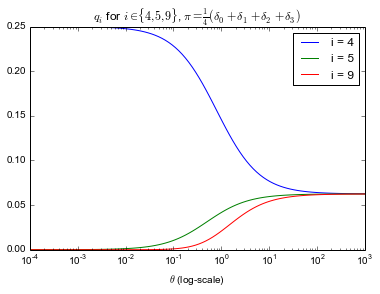

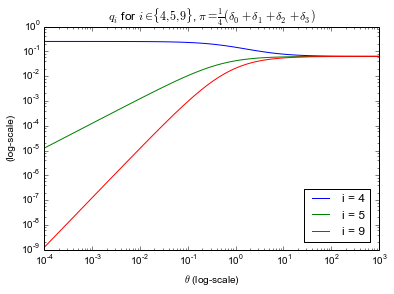

In [7]:
plt.figure(1)
#plt.subplot(211)
for i in (4,5,9):
    likelihhods = [solutions[(theta,pi1)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
#plt.legendnd()
plt.legend()
plt.xscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9\\}$, $\pi = \\frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3)$')
plt.show()
plt.close()

plt.figure(2)
#plt.subplot(212)
for i in (4,5,9):
    likelihhods = [solutions[(theta,pi1)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
#plt.legendnd()
plt.legend(bbox_to_anchor=(0.99, 0.30))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.ylabel('(log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9\\}$, $\pi = \\frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3)$')
plt.show()
plt.close()

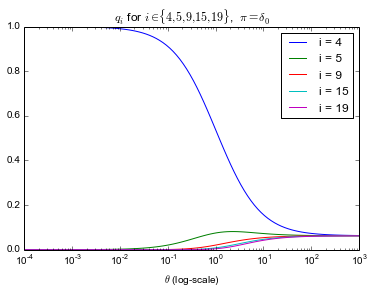

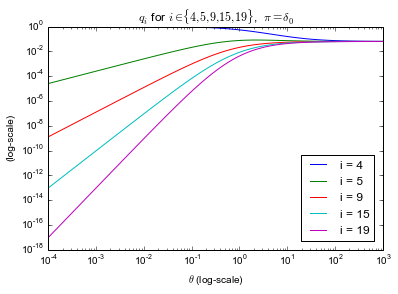

In [8]:
plt.figure(3)
for i in (4,5,9,15,19):
    likelihhods = [solutions[(theta,pi2)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
plt.xscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9,15,19\\}$,  $\pi = \delta_0$')
plt.legend()
plt.show()
plt.close()

plt.figure(3)
for i in (4,5,9,15,19):
    likelihhods = [solutions[(theta,pi2)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.ylabel('(log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9,15,19\\}$,  $\pi = \delta_0$')
plt.legend(bbox_to_anchor=(0.99, 0.45))
plt.show()
plt.close()

Below is an old function whuch I don't use anymore, but did not have the heart to throw out.

In [9]:
def printOctaveCode(theta,bdr_cnd):
    '''
    Prints octave code, for solving the linear system.
    Not used by me anymore, as I opted in the end for doing everything in python, but i kept it, as I might use it later.
    '''
    floatToStr = lambda x : "%.16f"%x
    
    b = np.r_[bdr_cnd[0],bdr_cnd[1],bdr_cnd[2],bdr_cnd[3],np.zeros(16)]
    M = coeficientMatrix(theta, d_mut, d_coal, d_rows)
    b_str = 'b = [%s]'%'\n     '.join(map(floatToStr,b))
    M_lines = [ ', '.join(map(floatToStr,[M[i,j] for j in range(M.shape[1])])) for i in range(M.shape[0])]
    M_str = 'M = [%s]'%'\n     '.join(M_lines)
    solveStr = 'linsolve(M,b)'
    
    print b_str,'\n'
    print M_str,'\n'
    print solveStr
#printOctaveCode(float(10**9),pi)